In [3]:
import os
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


In [4]:
csv_file = "/kaggle/input/headpose-data/headpose_merged.csv"

In [13]:
data = pd.read_csv(csv_file)
data.head()

,directory,filename,pitch,yaw,roll,direction
0,Front,personne09146+0+0.jpg,-0.016522,0.150272,0.004123,0
1,Front,personne06246+0+0.jpg,0.030302,0.042676,-0.183583,0
2,Front,personne01146+0+0.jpg,0.017203,-0.081454,-0.017137,0
3,Front,personne06146+0+0.jpg,0.069600,0.142844,-0.146851,0
4,Front,personne07146+0+0.jpg,0.047875,-0.220413,0.048016,0


In [14]:
y = data['direction']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: direction, dtype: int64

In [15]:
X = data.iloc[:, 2:-1]
X.head()

,pitch,yaw,roll
0,-0.016522,0.150272,0.004123
1,0.030302,0.042676,-0.183583
2,0.017203,-0.081454,-0.017137
3,0.069600,0.142844,-0.146851
4,0.047875,-0.220413,0.048016


In [16]:
len(X)

2816

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)

In [20]:
X_train

tensor([[ 0.0175, -0.0023, -0.0121],
        [ 0.0513,  0.0203,  0.3640],
        [ 0.7481, -0.7774,  0.5613],
        ...,
        [ 0.7292, -0.7931,  0.7953],
        [ 0.0250, -0.0101, -0.0141],
        [-0.0878,  0.3745,  0.0647]])

In [21]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

In [30]:
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)

In [39]:
class DirectionModel(nn.Module):
    def __init__(self, n_features, n_classes):
        super(DirectionModel, self).__init__()
        self.fc1 = nn.Linear(n_features, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(64, n_classes)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)
        
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        
        x = F.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.dropout3(x)
        
        x = self.fc4(x)
        return x

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
device

device(type='cpu')

In [81]:
model = DirectionModel(3, 5).to(device)
model

DirectionModel(
  (fc1): Linear(in_features=3, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=64, out_features=5, bias=True)
)

In [82]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [83]:
num_epochs = 200
accuracies = []
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    
        
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        _, val_predicted = torch.max(val_outputs, 1)
        val_accuracy = (val_predicted == y_test).sum().item() / len(y_test)
        accuracies.append(val_accuracy)
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
        print(f"Val Accuracy: {val_accuracy}")

Epoch 1/200, Loss: 1.426803708076477
Val Accuracy: 0.6808510638297872
Epoch 21/200, Loss: 0.6276732683181763
Val Accuracy: 0.851063829787234
Epoch 41/200, Loss: 0.6026838421821594
Val Accuracy: 0.8634751773049646
Epoch 61/200, Loss: 0.5270131826400757
Val Accuracy: 0.8687943262411347
Epoch 81/200, Loss: 1.5128592252731323
Val Accuracy: 0.8687943262411347
Epoch 101/200, Loss: 0.7276651859283447
Val Accuracy: 0.8794326241134752
Epoch 121/200, Loss: 0.5209352374076843
Val Accuracy: 0.874113475177305
Epoch 141/200, Loss: 0.7276928424835205
Val Accuracy: 0.8634751773049646
Epoch 161/200, Loss: 0.8251484036445618
Val Accuracy: 0.8670212765957447
Epoch 181/200, Loss: 0.3143598735332489
Val Accuracy: 0.8670212765957447


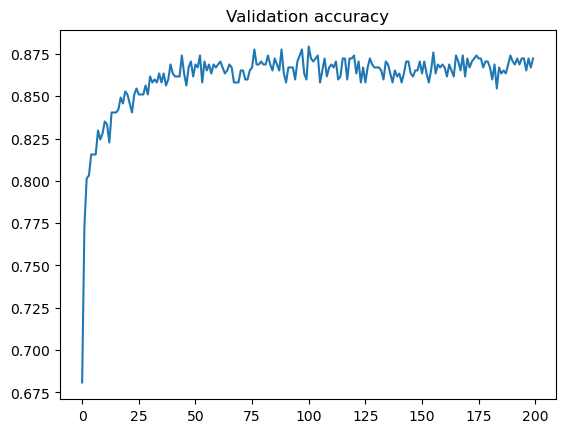

In [84]:
plt.plot(np.arange(len(accuracies)), accuracies)
plt.title("Validation accuracy")
plt.show()

In [85]:
torch.save(model.state_dict(), "direction_model.pt")

## 

In [86]:
path = "/kaggle/working/direction_model.pt"
!zip direction_model.zip {path}

updating: kaggle/working/direction_model.pt (deflated 8%)


In [87]:
from IPython.display import FileLink
FileLink('direction_model.zip')

/kaggle/working/direction_model.zip

In [90]:
np.average(accuracies[50:]) # Don't count early stages

0.8671985815602837